In [1]:
# import dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import tweepy
import matplotlib.pyplot as plt
from datetime import datetime
from api_keys import Twitter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# estalish twitter API keys
consumer_key = Twitter.consumer_key
consumer_secret = Twitter.consumer_secret
access_token = Twitter.access_token
access_token_secret = Twitter.access_token_secret

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# twitter accounts to search
target_accounts = ('@BBC', '@CBS', '@CNN', '@FoxNews', '@nytimes')

In [5]:
# analyze recent 100 tweets from news accounts
# create list to hold sentiments
sentiments = []

for account in target_accounts:
    
    # gather 100 recent tweets from news accounts
    public_tweets = api.user_timeline(id=account, count =100)
    
    # set tweet counter
    tweet_number = 100
    
    # loop through tweets
    for tweet in public_tweets:
        
        # retrive timestamp of tweet
        timestamp = tweet['created_at']
        converted_timestamp = datetime.strptime(timestamp, '%a %b %d %H:%M:%S %z %Y').date()
        
        # retrive tweet text
        text = tweet['text']
        
        # analyze tweet
        scores = analyzer.polarity_scores(text)
        
        # add news account to scores dictionary
        scores['News_Source'] = account
        
        # add date to scores dictionary
        scores['Date'] = converted_timestamp
        
        # add tweet Number to scores dictionary
        scores['Tweet_Number'] = tweet_number
        tweet_number -= 1
        
        # add scores dictionary to sentiments list
        sentiments.append(scores)

# create dataframe with tweet data
news_sentiment_df = pd.DataFrame(sentiments)
news_sentiment_df.head()

,Date,News_Source,Tweet_Number,compound,neg,neu,pos
0,2017-12-08,@BBC,100,0.0000,0.000,1.000,0.000
1,2017-12-08,@BBC,99,0.1027,0.104,0.769,0.126
2,2017-12-08,@BBC,98,0.5719,0.000,0.844,0.156
3,2017-12-08,@BBC,97,0.0000,0.000,1.000,0.000
4,2017-12-08,@BBC,96,-0.3182,0.087,0.913,0.000


In [6]:
# save data to csv
news_sentiment_df.to_csv('news_sentiments.csv')

In [7]:
# pivot dataframe for plotting
pivoted_df = news_sentiment_df.pivot(index='Tweet_Number', columns='News_Source', values='compound')
pivoted_df.head()

News_Source,@BBC,@CBS,@CNN,@FoxNews,@nytimes
Tweet_Number,,,,,
1,0.7713,0.5994,0.0000,0.8360,-0.6705
2,0.3400,0.0000,0.0000,-0.0258,-0.8126
3,0.6588,0.0000,-0.6214,0.0000,0.2500
4,-0.6486,0.0000,0.0000,0.2235,0.0000
5,0.0000,0.4939,0.0000,0.4927,-0.6486


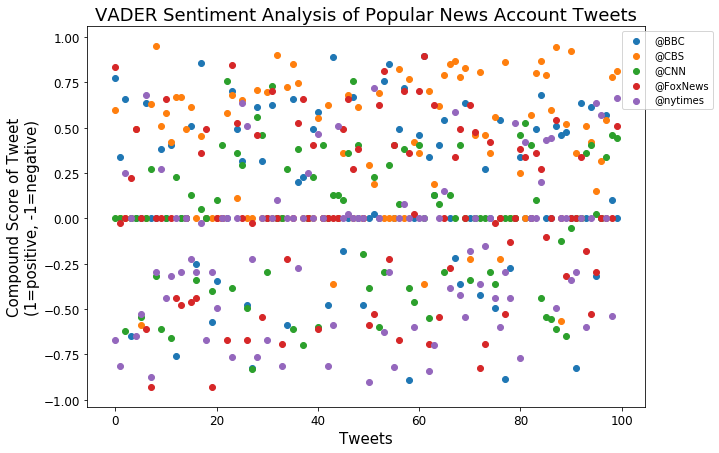

In [8]:
# plot compound scores on scatter plot

x_values = np.arange(100)

fig = plt.figure(figsize=(10, 7))

for news_source in target_accounts:
    
    plt.scatter(x_values, pivoted_df[news_source])

# add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.13, 1))

# change fontsize of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and axis labels
plt.title('VADER Sentiment Analysis of Popular News Account Tweets', fontsize=18)
plt.xlabel('Tweets', fontsize=15)
plt.ylabel('Compound Score of Tweet\n(1=positive, -1=negative)', fontsize=15)

# save plot
plt.savefig('sentiment_analysis_scatter.png')

plt.show()

In [9]:
# group by News_Source
grouped_df = news_sentiment_df.groupby('News_Source')

# calculate mean on compound scores
grouped_compound = grouped_df['compound'].mean()

grouped_compound

News_Source
@BBC        0.130120
@CBS        0.370750
@CNN       -0.010047
@FoxNews    0.043585
@nytimes   -0.143070
Name: compound, dtype: float64

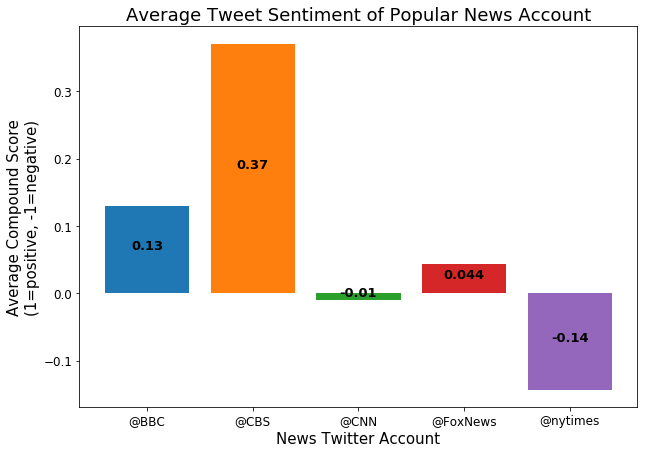

In [10]:
# plot mean compound scores
x_values = np.arange(len(target_accounts))

plot_data = zip(x_values, target_accounts)

fig = plt.figure(figsize=(10, 7))

for x, news_source in plot_data:
    
    y = grouped_compound[news_source]
    
    plt.bar(x, y)
    
    plt.text(x, y/2, '{:.2}'.format(y),
             horizontalalignment='center', color='black',
             fontsize=13, weight='bold')
    
# change xticks to news sources
plt.xticks(x_values, target_accounts)

# change fontsize of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and axis labels
plt.title('Average Tweet Sentiment of Popular News Account', fontsize=18)
plt.xlabel('News Twitter Account', fontsize=15)
plt.ylabel('Average Compound Score\n(1=positive, -1=negative)', fontsize=15)

# save plot
plt.savefig('average_sentiment_bar.png')

plt.show()